In [2]:
import numpy as np
import random
import sys

def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

class BoardPiece:

    def __init__(self, name, code, pos):
        self.name = name #name of the piece
        self.code = code #an ASCII character to display on the board
        self.pos = pos #2-tuple e.g. (1,4)

class BoardMask:

    def __init__(self, name, mask, code):
        self.name = name
        self.mask = mask
        self.code = code

    def get_positions(self): #returns tuple of arrays
        return np.nonzero(self.mask)

def zip_positions2d(positions): #positions is tuple of two arrays
    x,y = positions
    return list(zip(x,y))

class GridBoard:

    def __init__(self, size=4):
        self.size = size #Board dimensions, e.g. 4 x 4
        self.components = {} #name : board piece
        self.masks = {}

    def addPiece(self, name, code, pos=(0,0)):
        newPiece = BoardPiece(name, code, pos)
        self.components[name] = newPiece

    #basically a set of boundary elements
    def addMask(self, name, mask, code):
        #mask is a 2D-numpy array with 1s where the boundary elements are
        newMask = BoardMask(name, mask, code)
        self.masks[name] = newMask

    def movePiece(self, name, pos):
        move = True
        for _, mask in self.masks.items():
            if pos in zip_positions2d(mask.get_positions()):
                move = False
        if move:
            self.components[name].pos = pos

    def delPiece(self, name):
        del self.components['name']

    def render(self):
        dtype = '<U2'
        displ_board = np.zeros((self.size, self.size), dtype=dtype)
        displ_board[:] = ' '

        for name, piece in self.components.items():
            displ_board[piece.pos] = piece.code

        for name, mask in self.masks.items():
            displ_board[mask.get_positions()] = mask.code

        return displ_board

    def render_np(self):
        num_pieces = len(self.components) + len(self.masks)
        displ_board = np.zeros((num_pieces, self.size, self.size), dtype=np.uint8)
        layer = 0
        for name, piece in self.components.items():
            pos = (layer,) + piece.pos
            displ_board[pos] = 1
            layer += 1

        for name, mask in self.masks.items():
            x,y = self.masks['boundary'].get_positions()
            z = np.repeat(layer,len(x))
            a = (z,x,y)
            displ_board[a] = 1
            layer += 1
        return displ_board

def addTuple(a,b):
    return tuple([sum(x) for x in zip(a,b)])

In [3]:
class Gridworld:
    def __init__(self, size=4, mode='static'):
        if size >= 4:
            self.board = GridBoard(size=size)
        else:
            print("Minimum board size is 4. Initialized to size 4.")
            self.board = GridBoard(size=4)

        #Add pieces, positions will be updated later
        self.board.addPiece('Player','P',(0,0))
        self.board.addPiece('Goal','+',(1,0))
        self.board.addPiece('Pit','-',(2,0))
        self.board.addPiece('Wall','W',(3,0))

        if mode == 'static':
            self.initGridStatic()
        elif mode == 'player':
            self.initGridPlayer()
        else:
            self.initGridRand()
            
    #Initialize stationary grid, all items are placed deterministically
    def initGridStatic(self):
        #Setup static pieces
        self.board.components['Player'].pos = (0,3) #Row, Column
        self.board.components['Goal'].pos = (0,0)
        self.board.components['Pit'].pos = (0,1)
        self.board.components['Wall'].pos = (1,1)

    #Check if board is initialized appropriately (no overlapping pieces)
    #also remove impossible-to-win boards
    def validateBoard(self):
        valid = True

        player = self.board.components['Player']
        goal = self.board.components['Goal']
        wall = self.board.components['Wall']
        pit = self.board.components['Pit']

        all_positions = [piece for name,piece in self.board.components.items()]
        all_positions = [player.pos, goal.pos, wall.pos, pit.pos]
        if len(all_positions) > len(set(all_positions)):
            return False

        corners = [(0,0),(0,self.board.size), (self.board.size,0), (self.board.size,self.board.size)]
        #if player is in corner, can it move? if goal is in corner, is it blocked?
        if player.pos in corners or goal.pos in corners:
            val_move_pl = [self.validateMove('Player', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            val_move_go = [self.validateMove('Goal', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            if 0 not in val_move_pl or 0 not in val_move_go:
                #print(self.display())
                #print("Invalid board. Re-initializing...")
                valid = False

        return valid

    #Initialize player in random location, but keep wall, goal and pit stationary
    def initGridPlayer(self):
        #height x width x depth (number of pieces)
        self.initGridStatic()
        #place player
        self.board.components['Player'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridPlayer()

    #Initialize grid so that goal, pit, wall, player are all randomly placed
    def initGridRand(self):
        #height x width x depth (number of pieces)
        self.board.components['Player'].pos = randPair(0,self.board.size)
        self.board.components['Goal'].pos = randPair(0,self.board.size)
        self.board.components['Pit'].pos = randPair(0,self.board.size)
        self.board.components['Wall'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridRand()

    def validateMove(self, piece, addpos=(0,0)):
        outcome = 0 #0 is valid, 1 invalid, 2 lost game
        pit = self.board.components['Pit'].pos
        wall = self.board.components['Wall'].pos
        new_pos = addTuple(self.board.components[piece].pos, addpos)
        if new_pos == wall:
            outcome = 1 #block move, player can't move to wall
        elif max(new_pos) > (self.board.size-1):    #if outside bounds of board
            outcome = 1
        elif min(new_pos) < 0: #if outside bounds
            outcome = 1
        elif new_pos == pit:
            outcome = 2

        return outcome

    def makeMove(self, action, x):
        #need to determine what object (if any) is in the new grid spot the player is moving to
        #actions in {u,d,l,r}
        def checkMove(addpos):
            if self.validateMove('Player', addpos) in [0,2]:
                new_pos = addTuple(self.board.components['Player'].pos, addpos)
                self.board.movePiece('Player', new_pos)
        
        string = f'{"Arrow"}{x}'
        if action == 'u': #up
            self.board.addPiece(string,'u',self.board.components['Player'].pos)
            x = x + 1
            checkMove((-1,0))
        elif action == 'd': #down
            self.board.addPiece(string,'d',self.board.components['Player'].pos)
            x = x + 1
            checkMove((1,0))
        elif action == 'l': #left
            self.board.addPiece(string,'l',self.board.components['Player'].pos)
            checkMove((0,-1))
            x = x + 1
        elif action == 'r': #right
            self.board.addPiece(string,'r',self.board.components['Player'].pos)
            checkMove((0,1))
            x = x + 1
        else:
            pass

    def reward(self):
        if (self.board.components['Player'].pos == self.board.components['Pit'].pos):
            return -10
        elif (self.board.components['Player'].pos == self.board.components['Goal'].pos):
            return 10
        else:
            return -1

    def display(self):
        return self.board.render()
    
    def render_np(self):
        displ_board = np.zeros(( 4,  4), dtype = np.uint8)
        displ_board[self.board.components['Player'].pos] = 1
        displ_board[self.board.components['Goal'].pos] = 2
        displ_board[self.board.components['Pit'].pos] = 3
        displ_board[self.board.components['Wall'].pos] = 4
        return displ_board

In [58]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [59]:
game = Gridworld(size=4, mode='static')
game.render_np()

array([[2, 3, 0, 1],
       [0, 4, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=uint8)

In [60]:
game.render_np().reshape(1,16)

array([[2, 3, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [63]:
state_ = game.render_np().reshape(1,16) + np.random.rand(1,16)/10.0 #D
state_

array([[2.04176765, 3.053605  , 0.07843958, 1.00337445, 0.059245  ,
        4.0570879 , 0.05060568, 0.06420394, 0.01205762, 0.09653189,
        0.07274019, 0.0057028 , 0.06241457, 0.088931  , 0.09698202,
        0.00612502]])

In [102]:
import numpy as np
import torch
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
l1 = 16
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

epochs = 500
losses = [] #A
w, h = 23, 100000
matrix = [[0 for x in range(w)] for y in range(h)] 
counter = 0
for i in range(epochs): #B
    game = Gridworld(size=4, mode='random') #C
    state_ = game.render_np().reshape(1,16) + np.random.rand(1,16)/10.0 #D
    state1 = torch.from_numpy(state_).float() #E
    status = 1 #F
    while(status == 1): #G
        matrix[counter][5] = epsilon 
        matrix[counter][0] = i + 1
        matrix[counter][1] = (str(game.board.components['Player'].pos))
        matrix[counter][11] = (str(game.board.components['Pit'].pos))
        matrix[counter][12] = (str(game.board.components['Goal'].pos))
        matrix[counter][13] = (str(game.board.components['Wall'].pos))

        qval = model(state1) #H
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #I
            matrix[counter][4] = 1 
            action_ = np.random.randint(0,4)
        else:
            matrix[counter][4] = 0 
            action_ = np.argmax(qval_)
        action = action_set[action_] #J
        matrix[counter][6] = action_
        matrix[counter][14] = round(list(model.parameters())[5][0].item(),6)
        matrix[counter][15] = round(list(model.parameters())[5][0].item(),6)
        matrix[counter][16] = round(list(model.parameters())[5][0].item(),6)
        matrix[counter][17] = round(list(model.parameters())[5][0].item(),6)
        game.makeMove(action, counter) #K
        state2_ = game.render_np().reshape(1,16) + np.random.rand(1,16)/10.0
        state2 = torch.from_numpy(state2_).float() #L
        reward = game.reward()
        with torch.no_grad():
        maxQ = model(state2.reshape(1,16))
        maxQ = torch.max(maxQ) #M
        matrix[counter][8] = maxQ.item()
        if reward == -1: #N
            matrix[counter][3] = -1 
            Y = reward + (gamma * maxQ)
        else:
            matrix[counter][3] = reward 
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] #O


        matrix[counter][7] = X.item()
        matrix[counter][9] = Y.item()
        loss = loss_fn(X, Y) #P
        print(i, loss.item())
        clear_output(wait=True)
        matrix[counter][10] = loss.item()
#             print(i, loss.item())
#             clear_output(wait=True)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        state1 = state2
        matrix[counter][2] = (str(game.board.components['Player'].pos))
        matrix[counter][18] = round(list(model.parameters())[5][0].item(),6)
        matrix[counter][19] = round(list(model.parameters())[5][1].item(),6)
        matrix[counter][20] = round(list(model.parameters())[5][2].item(),6)
        matrix[counter][21] = round(list(model.parameters())[5][3].item(),6)
        matrix[counter][22] = counter + 1

        counter = counter + 1 
        if reward != -1: #Q
            status = 0
    if epsilon > 0.1: #R
        epsilon -= (1/epochs)

499 0.02218286506831646


In [103]:
game = Gridworld(size=4, mode='static')
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [104]:
game.makeMove("d", 0)
game.makeMove("d", 1)

In [105]:
game.display()

array([['+', '-', ' ', 'd'],
       [' ', 'W', ' ', 'd'],
       [' ', ' ', ' ', 'P'],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [106]:
import pandas as pd
column_names = ["Epochs","Current_State", "Next_State", "Reward","Epsilon_Boolean", "Epsilon", "Action",
                "Current_Q_Value", "Next_Q_Value","Reawrd_Plus_Next_Q_Value", "Loss",
                "Pit_Position", "Goal_Position", "Wall_Position",
                "CurWeight[0]", "CurWeight[1]", "CurWeight[2]", "CurWeight[3]",
                "NextWeight[0]","NextWeight[1]","NextWeight[2]","NextWeight[3]", "Step" 
                ]
df = pd.DataFrame(matrix, columns = column_names)
df = df.loc[(df != 0).any(axis=1)]
# mapping = {"Epochs":"Epochs","Next_State":"Next_State","Reward":"Reward","Cuttent_State":"Cuttent_State",
#            "Epsilon_Boolean":"Epsilon_Boolean","Epsilon":"Epsilon",
#            "Action":"Action", "Current_Q_Value":"Current_Q_Value",
#            "Next_Q_Value":"Next_Q_Value", "Reawrd_Plus_Next_Q_Value":"Reawrd_Plus_Next_Q_Value",
#            "Loss":"Loss","Pit_Position":"Pit_Position", "Goal_Position": "Goal_Position",
#            "Wall_Position":"Wall_Position",
#            'Model_Param_Current[0]': 'Current_Model_Parameters', 'Model_Param_Current[1]': 'Current_Model_Parameters',
#            'Model_Param_Current[2]': 'Current_Model_Parameters', 'Model_Param_Current[3]': 'Current_Model_Parameters',
#            'Model_Param_Next[0]': 'Next_Model_Parameters', 'Model_Param_Next[1]': 'Next_Model_Parameters',
#            'Model_Param_Next[2]': 'Next_Model_Parameters', 'Model_Param_Next[3]': 'Next_Model_Parameters',   
#           }
# df = df.set_index('Step').groupby(mapping, axis = 1).sum()
  
# df.reset_index(level = 0)
sliced_df = pd.concat([df.head(10), df.tail(10)])
sliced_df

,Epochs,Current_State,Next_State,Reward,Epsilon_Boolean,Epsilon,Action,Current_Q_Value,Next_Q_Value,Reawrd_Plus_Next_Q_Value,...,Wall_Position,CurWeight[0],CurWeight[1],CurWeight[2],CurWeight[3],NextWeight[0],NextWeight[1],NextWeight[2],NextWeight[3],Step
0,1,"(2, 1)","(2, 0)",-1,1,1.0,2,0.133576,0.188658,-0.830208,...,"(1, 1)",0.039634,0.039634,0.039634,0.039634,0.039634,-0.002385,-0.061416,-0.090984,1
1,1,"(2, 0)","(2, 0)",-1,1,1.0,2,-0.007616,0.020587,-0.981472,...,"(1, 1)",0.039634,0.039634,0.039634,0.039634,0.039634,-0.002385,-0.062417,-0.090984,2
2,1,"(2, 0)","(1, 0)",-1,1,1.0,0,0.005532,0.025501,-0.977049,...,"(1, 1)",0.039634,0.039634,0.039634,0.039634,0.038995,-0.002385,-0.063190,-0.090984,3
3,1,"(1, 0)","(1, 0)",-1,1,1.0,3,0.046306,0.045076,-0.959432,...,"(1, 1)",0.038995,0.038995,0.038995,0.038995,0.038471,-0.002385,-0.063823,-0.091565,4
4,1,"(1, 0)","(2, 0)",-1,1,1.0,1,-0.046934,0.031620,-0.971542,...,"(1, 1)",0.038471,0.038471,0.038471,0.038471,0.038029,-0.002931,-0.064358,-0.092057,5
5,1,"(2, 0)","(2, 0)",-1,1,1.0,2,-0.452512,-0.005524,-1.004972,...,"(1, 1)",0.038029,0.038029,0.038029,0.038029,0.037648,-0.003401,-0.064982,-0.092480,6
6,1,"(2, 0)","(3, 0)",-1,1,1.0,1,-0.150719,-0.056418,-1.050777,...,"(1, 1)",0.037648,0.037648,0.037648,0.037648,0.037315,-0.004048,-0.065526,-0.092850,7
7,1,"(3, 0)","(3, 0)",-1,1,1.0,1,-0.188259,-0.082891,-1.074602,...,"(1, 1)",0.037315,0.037315,0.037315,0.037315,0.037022,-0.004800,-0.066006,-0.093176,8
8,1,"(3, 0)","(3, 0)",-1,1,1.0,2,-0.695193,-0.104236,-1.093813,...,"(1, 1)",0.037022,0.037022,0.037022,0.037022,0.036761,-0.005466,-0.066545,-0.093465,9
9,1,"(3, 0)","(2, 0)",-1,1,1.0,0,-0.211449,-0.099059,-1.089153,...,"(1, 1)",0.036761,0.036761,0.036761,0.036761,0.036265,-0.006062,-0.067026,-0.093723,10


In [107]:
game.render_np().reshape(1,16)

array([[2, 3, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=uint8)

In [108]:
def test_model(model,policy,policy_counter,matrix,mode='static', display=True):
    i = 0

    test_game = Gridworld(mode=mode)
    state_ = test_game.render_np().reshape(1,16) + np.random.rand(1,16)/10.0
    state = torch.from_numpy(state_).float()
    clear_output(wait=True)
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    counter = 0
    
    policy[policy_counter][0] = (str(test_game.board.components['Player'].pos))
    policy[policy_counter][1] = (str(test_game.board.components['Pit'].pos))
    policy[policy_counter][2] = (str(test_game.board.components['Goal'].pos))
    policy[policy_counter][3] = (str(test_game.board.components['Wall'].pos))
    action_policy = ""
    while(status == 1): #A
        matrix[counter][0] = (str(test_game.board.components['Player'].pos))
        matrix[counter][5] = (str(test_game.board.components['Pit'].pos))
        matrix[counter][6] = (str(test_game.board.components['Goal'].pos))
        matrix[counter][7] = (str(test_game.board.components['Wall'].pos))
        qval = model(state)
        qval_ = qval.data.numpy()
        matrix[counter][8] = str(qval_[0]) 
        action_ = np.argmax(qval_) #B
        matrix[counter][9] = np.argmax(qval_)
        action = action_set[action_]
        matrix[counter][2] = action 
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action, counter)
        action_policy = action_policy + action
        matrix[counter][1] = (str(test_game.board.components['Player'].pos))
        state_ = test_game.render_np().reshape(1,16) + np.random.rand(1,16)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        matrix[counter][3] = reward
        matrix[counter][4] = i
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        counter = counter + 1 
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    policy[policy_counter][4] = action_policy  
    win = True if status == 2 else False
    return win

Initial State:
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']]
Move #: 0; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 ['u' ' ' ' ' ' ']]
Move #: 1; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 ['u' ' ' ' ' ' ']
 ['u' ' ' ' ' ' ']]
Move #: 2; Taking action: u
[['+' '-' ' ' ' ']
 ['u' 'W' ' ' ' ']
 ['u' ' ' ' ' ' ']
 ['u' ' ' ' ' ' ']]
Game won! Reward: 10
Games played: 1000, # of wins: 1000
Win percentage: 100.0%


Text(0, 0.5, 'Loss')

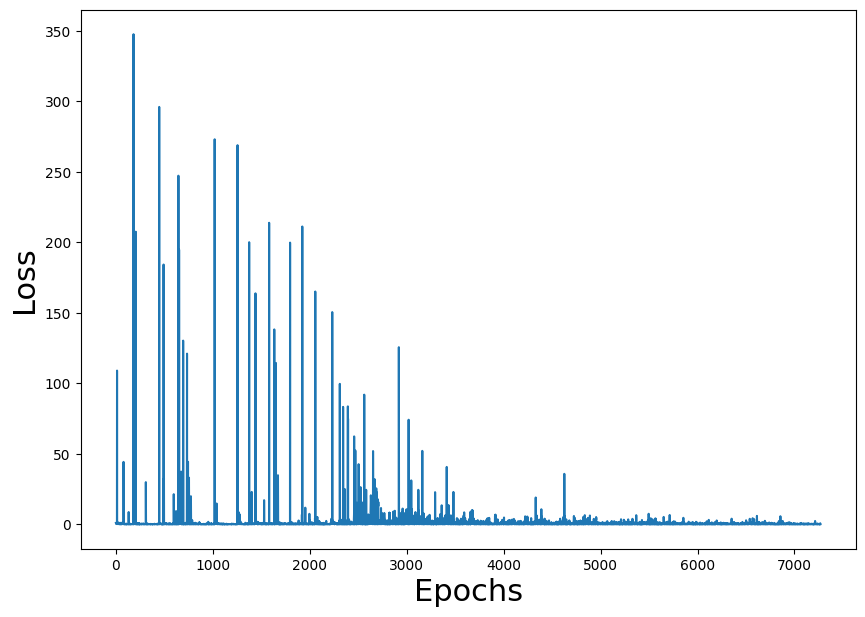

In [109]:
w, h = 5, 10000
policy_matrix = [[0 for x in range(w)] for y in range(h)] 

w, h = 10, 10000
matrix = [[0 for x in range(w)] for y in range(h)] 
    
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, policy_matrix, i, matrix, mode='player')
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [110]:
policy_matrix

[['(2, 2)', '(0, 1)', '(0, 0)', '(1, 1)', 'lluu'],
 ['(3, 0)', '(0, 1)', '(0, 0)', '(1, 1)', 'uuu'],
 ['(2, 0)', '(0, 1)', '(0, 0)', '(1, 1)', 'uu'],
 ['(1, 3)', '(0, 1)', '(0, 0)', '(1, 1)', 'dllluu'],
 ['(3, 2)', '(0, 1)', '(0, 0)', '(1, 1)', 'lluuu'],
 ['(3, 0)', '(0, 1)', '(0, 0)', '(1, 1)', 'uuu'],
 ['(0, 2)', '(0, 1)', '(0, 0)', '(1, 1)', 'ddlluu'],
 ['(3, 1)', '(0, 1)', '(0, 0)', '(1, 1)', 'luuu'],
 ['(0, 3)', '(0, 1)', '(0, 0)', '(1, 1)', 'ddllluu'],
 ['(3, 3)', '(0, 1)', '(0, 0)', '(1, 1)', 'llluuu'],
 ['(2, 0)', '(0, 1)', '(0, 0)', '(1, 1)', 'uu'],
 ['(2, 0)', '(0, 1)', '(0, 0)', '(1, 1)', 'uu'],
 ['(0, 2)', '(0, 1)', '(0, 0)', '(1, 1)', 'ddlluu'],
 ['(0, 2)', '(0, 1)', '(0, 0)', '(1, 1)', 'ddlluu'],
 ['(2, 1)', '(0, 1)', '(0, 0)', '(1, 1)', 'luu'],
 ['(2, 3)', '(0, 1)', '(0, 0)', '(1, 1)', 'llluu'],
 ['(3, 3)', '(0, 1)', '(0, 0)', '(1, 1)', 'llluuu'],
 ['(0, 3)', '(0, 1)', '(0, 0)', '(1, 1)', 'ddllluu'],
 ['(1, 3)', '(0, 1)', '(0, 0)', '(1, 1)', 'ldlluu'],
 ['(3, 0)', '(0, 1

In [68]:
matrix

[['(0, 3)',
  '(1, 3)',
  'd',
  -1,
  0,
  '(0, 1)',
  '(0, 0)',
  '(1, 1)',
  '[-1.4701279   0.7948443  -0.675373    0.07781003]',
  1],
 ['(1, 3)',
  '(2, 3)',
  'd',
  -1,
  1,
  '(0, 1)',
  '(0, 0)',
  '(1, 1)',
  '[-0.9211335   1.3960037  -0.1099861   0.54603225]',
  1],
 ['(2, 3)',
  '(2, 2)',
  'l',
  -1,
  2,
  '(0, 1)',
  '(0, 0)',
  '(1, 1)',
  '[0.53451025 1.6288464  2.5202928  0.9786203 ]',
  2],
 ['(2, 2)',
  '(2, 1)',
  'l',
  -1,
  3,
  '(0, 1)',
  '(0, 0)',
  '(1, 1)',
  '[0.2889419 1.7355812 3.3778477 1.0573852]',
  2],
 ['(2, 1)',
  '(2, 0)',
  'l',
  -1,
  4,
  '(0, 1)',
  '(0, 0)',
  '(1, 1)',
  '[3.8047457 2.1176364 5.8682966 1.9379512]',
  2],
 ['(2, 0)',
  '(1, 0)',
  'u',
  -1,
  5,
  '(0, 1)',
  '(0, 0)',
  '(1, 1)',
  '[8.069663  2.6173644 4.9231663 2.8345704]',
  0],
 ['(1, 0)',
  '(0, 0)',
  'u',
  10,
  6,
  '(0, 1)',
  '(0, 0)',
  '(1, 1)',
  '[9.797725  2.6948957 4.9380727 2.9593291]',
  0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [69]:
import pandas as pd
column_names = ["Current_Player_Position", "Next_Player_Position", "Action", "Reward", "Counter", 
                "Pit_Position", "Goal_Position", "Wall_Position", "Q_Vals", 'max_Q_value'
                ]
df = pd.DataFrame(matrix, columns = column_names)
df = df.loc[(df != 0).any(axis=1)]

In [70]:
df

,Current_Player_Position,Next_Player_Position,Action,Reward,Counter,Pit_Position,Goal_Position,Wall_Position,Q_Vals,max_Q_value
0,"(0, 3)","(1, 3)",d,-1,0,"(0, 1)","(0, 0)","(1, 1)",[-1.4701279 0.7948443 -0.675373 0.07781003],1
1,"(1, 3)","(2, 3)",d,-1,1,"(0, 1)","(0, 0)","(1, 1)",[-0.9211335 1.3960037 -0.1099861 0.54603225],1
2,"(2, 3)","(2, 2)",l,-1,2,"(0, 1)","(0, 0)","(1, 1)",[0.53451025 1.6288464 2.5202928 0.9786203 ],2
3,"(2, 2)","(2, 1)",l,-1,3,"(0, 1)","(0, 0)","(1, 1)",[0.2889419 1.7355812 3.3778477 1.0573852],2
4,"(2, 1)","(2, 0)",l,-1,4,"(0, 1)","(0, 0)","(1, 1)",[3.8047457 2.1176364 5.8682966 1.9379512],2
5,"(2, 0)","(1, 0)",u,-1,5,"(0, 1)","(0, 0)","(1, 1)",[8.069663 2.6173644 4.9231663 2.8345704],0
6,"(1, 0)","(0, 0)",u,10,6,"(0, 1)","(0, 0)","(1, 1)",[9.797725 2.6948957 4.9380727 2.9593291],0


In [23]:
import pandas as pd
column_names = ["Player_Position",
                "Pit_Position", "Goal_Position", "Wall_Position",
                "Action_Policy", "Q_Vals", 'max_Q_value'
                ]
df = pd.DataFrame(policy_matrix, columns = column_names)
df = df.loc[(df != 0).any(axis=1)]

In [24]:
df

,Player_Position,Pit_Position,Goal_Position,Wall_Position,Action_Policy,Q_Vals
0,"(0, 3)","(0, 1)","(0, 0)","(1, 1)",ddllluu,9.786899/2.6935182/4.9598103/2.9557116
1,"(0, 3)","(0, 1)","(0, 0)","(1, 1)",ddllluu,9.853883/2.7043405/4.950577/2.9720397
2,"(0, 3)","(0, 1)","(0, 0)","(1, 1)",ddllluu,9.821472/2.6979613/4.9786825/2.9569917
3,"(0, 3)","(0, 1)","(0, 0)","(1, 1)",ddllluu,9.780889/2.690327/5.024719/2.9359286
4,"(0, 3)","(0, 1)","(0, 0)","(1, 1)",ddllluu,9.941258/2.7033277/4.892213/2.98478
...,...,...,...,...,...,...
995,"(0, 3)","(0, 1)","(0, 0)","(1, 1)",ddllluu,9.70552/2.6746774/4.9369106/2.9319148
996,"(0, 3)","(0, 1)","(0, 0)","(1, 1)",ddllluu,9.867383/2.6861491/4.8925257/2.958718
997,"(0, 3)","(0, 1)","(0, 0)","(1, 1)",ddllluu,9.938685/2.719398/4.8952775/3.0057633
998,"(0, 3)","(0, 1)","(0, 0)","(1, 1)",ddllluu,9.779929/2.6874318/5.0309067/2.9287956


# Experience Replay Player

In [71]:
l1 = 16
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [116]:
from collections import deque
epochs = 00
losses = []
mem_size = 1000 #A
batch_size = 200 #B
replay = deque(maxlen=mem_size) #C
max_moves = 50 #D
h = 0
counter = 0

w, h = 10, 10000
matrix = [[0 for x in range(w)] for y in range(h)] 

for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.render_np().reshape(1,16) + np.random.rand(1,16)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) #E
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #F
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action, counter)
        state2_ = game.render_np().reshape(1,16) + np.random.rand(1,16)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done) #G
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size: #I
            minibatch = random.sample(replay, batch_size) #J
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #K
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #L
            with torch.no_grad():
                Q2 = model(state2_batch) #M
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #N
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
        counter = counter + 1
        if reward != -1 or mov > max_moves: #O
            status = 0
            mov = 0
losses = np.array(losses)

999 1.5690804719924927


Text(0, 0.5, 'Loss')

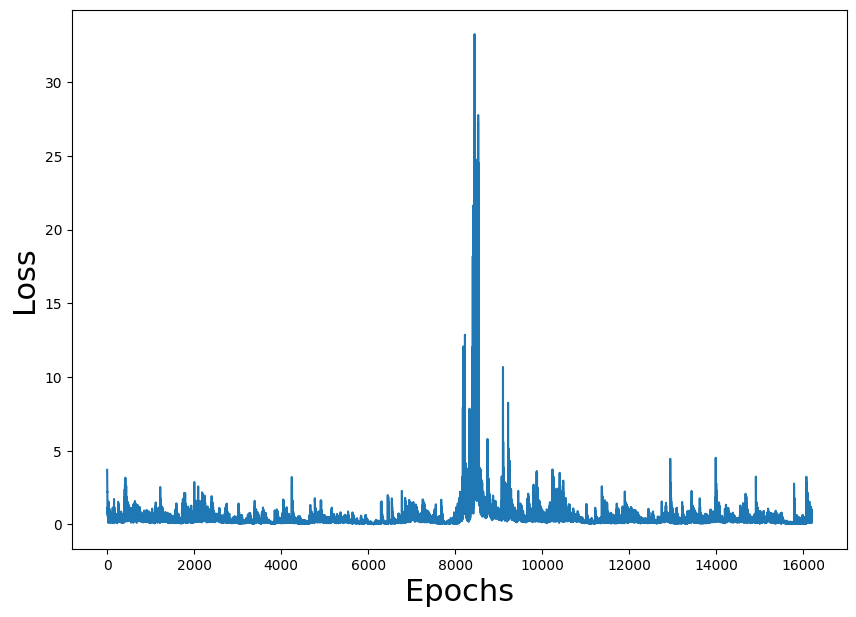

In [112]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

Initial State:
[[' ' '+' 'W' ' ']
 [' ' ' ' '-' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: u
[[' ' '+' 'W' ' ']
 [' ' ' ' '-' ' ']
 [' ' ' ' 'u' ' ']
 [' ' ' ' ' ' ' ']]
Game LOST. Reward: -10
Games played: 1000, # of wins: 91
Win percentage: 9.1%


Text(0, 0.5, 'Loss')

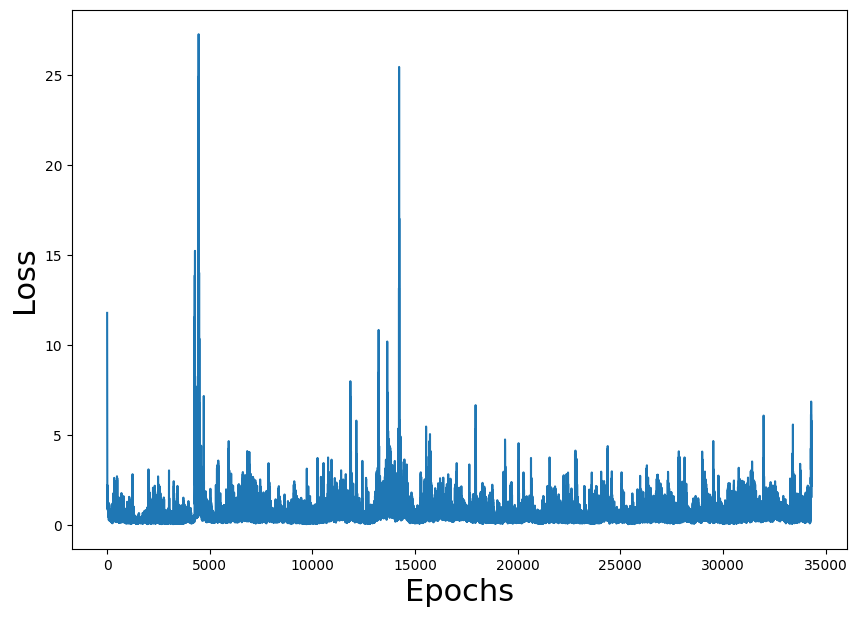

In [117]:
w, h = 5, 10000
policy_matrix = [[0 for x in range(w)] for y in range(h)] 

w, h = 10, 10000
matrix = [[0 for x in range(w)] for y in range(h)] 
    
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, policy_matrix, i, matrix, mode='random')
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [21]:
policy_matrix

[['(1, 0)', '(0, 1)', '(0, 0)', '(1, 1)', 'u'],
 ['(2, 3)', '(0, 1)', '(0, 0)', '(1, 1)', 'llluu'],
 ['(2, 1)', '(0, 1)', '(0, 0)', '(1, 1)', 'luu'],
 ['(2, 2)', '(0, 1)', '(0, 0)', '(1, 1)', 'lluu'],
 ['(3, 2)', '(0, 1)', '(0, 0)', '(1, 1)', 'lluuu'],
 ['(3, 3)', '(0, 1)', '(0, 0)', '(1, 1)', 'llluuu'],
 ['(0, 2)', '(0, 1)', '(0, 0)', '(1, 1)', 'ddlluu'],
 ['(2, 2)', '(0, 1)', '(0, 0)', '(1, 1)', 'lluu'],
 ['(3, 1)', '(0, 1)', '(0, 0)', '(1, 1)', 'luuu'],
 ['(0, 3)', '(0, 1)', '(0, 0)', '(1, 1)', 'lddlluu'],
 ['(1, 2)', '(0, 1)', '(0, 0)', '(1, 1)', 'dlluu'],
 ['(1, 0)', '(0, 1)', '(0, 0)', '(1, 1)', 'u'],
 ['(3, 2)', '(0, 1)', '(0, 0)', '(1, 1)', 'lluuu'],
 ['(3, 2)', '(0, 1)', '(0, 0)', '(1, 1)', 'lluuu'],
 ['(2, 2)', '(0, 1)', '(0, 0)', '(1, 1)', 'lluu'],
 ['(1, 3)', '(0, 1)', '(0, 0)', '(1, 1)', 'ldlluu'],
 ['(3, 2)', '(0, 1)', '(0, 0)', '(1, 1)', 'lluuu'],
 ['(3, 1)', '(0, 1)', '(0, 0)', '(1, 1)', 'luuu'],
 ['(1, 0)', '(0, 1)', '(0, 0)', '(1, 1)', 'u'],
 ['(3, 0)', '(0, 1)', '(0,

In [22]:
import pandas as pd
column_names = ["Player_Position",
                "Pit_Position", "Goal_Position", "Wall_Position",
                "Action_Policy"
                ]
df = pd.DataFrame(policy_matrix, columns = column_names)
df = df.loc[(df != 0).any(axis=1)]

In [23]:
new_df = pd.concat([df.head(10), df.tail(10)])
new_df

,Player_Position,Pit_Position,Goal_Position,Wall_Position,Action_Policy
0,"(1, 0)","(0, 1)","(0, 0)","(1, 1)",u
1,"(2, 3)","(0, 1)","(0, 0)","(1, 1)",llluu
2,"(2, 1)","(0, 1)","(0, 0)","(1, 1)",luu
3,"(2, 2)","(0, 1)","(0, 0)","(1, 1)",lluu
4,"(3, 2)","(0, 1)","(0, 0)","(1, 1)",lluuu
5,"(3, 3)","(0, 1)","(0, 0)","(1, 1)",llluuu
6,"(0, 2)","(0, 1)","(0, 0)","(1, 1)",ddlluu
7,"(2, 2)","(0, 1)","(0, 0)","(1, 1)",lluu
8,"(3, 1)","(0, 1)","(0, 0)","(1, 1)",luuu
9,"(0, 3)","(0, 1)","(0, 0)","(1, 1)",lddlluu


In [24]:
game = Gridworld(size=4, mode='static')
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [25]:
game.makeMove('u', 2292092)
game.display()

array([['+', '-', ' ', 'u'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [26]:
game = Gridworld(size=4, mode='static')

In [27]:
counter = 0
for i in range (0,1000):
    game = Gridworld(size=4, mode='static')
    
    for actions in df["Action_Policy"][i]:
        game.makeMove(actions, counter)
        counter = counter + 1
        print(game.display())

[['+' '-' ' ' 'u']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'P' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'l' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' 'l' 'l' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['u' 'l' 'l' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['u' 'l' 'l' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'P' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'u' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'u' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'P' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'l' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' 'u' 'l' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' 'u' 'l' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]

[['+' 'u' 'l' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' 'u' 'l' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'P' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'd' 'l']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'd' 'l']
 [' ' 'W' 'l' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'd' 'l']
 [' ' 'W' 'l' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'd' 'l']
 [' ' 'W' 'u' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'u' 'l']
 [' ' 'W' 'u' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' ' ' 'd']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' ' ' 'd']
 [' ' 'W' 'P' 'l']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' ' ' 'd']
 [' ' 'W' 'l' 'l']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'P' 'd']
 [' ' 'W' 'u' 'l']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'u' 'd']
 [' ' 'W' 'u' 'l']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]

[['+' '-' 'd' 'l']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'd' 'l']
 [' ' 'W' 'd' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'd' 'l']
 [' ' 'W' 'd' ' ']
 [' ' 'P' 'l' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'd' 'l']
 [' ' 'W' 'd' ' ']
 ['P' 'l' 'l' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'd' 'l']
 ['P' 'W' 'd' ' ']
 ['u' 'l' 'l' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'd' 'l']
 ['u' 'W' 'd' ' ']
 ['u' 'l' 'l' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'P' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'l' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' 'l' 'l' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['u' 'l' 'l' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['u' 'l' 'l' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['u' 'l' 'l' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
[['+' '-' 'P' 'l']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]

# # Experience Replay Random

In [75]:
l1 = 16
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [76]:
from collections import deque
epochs = 500
losses = []
mem_size = 1000 #A
batch_size = 200 #B
replay = deque(maxlen=mem_size) #C
max_moves = 50 #D
h = 0
counter = 0

w, h = 11, 10000
matrix = [[0 for x in range(w)] for y in range(h)] 

for i in range(epochs):
    game = Gridworld(size=4, mode='player')
    state1_ = game.render_np().reshape(1,16) + np.random.rand(1,16)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) #E
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #F
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        
        matrix[counter][0] = i + 1
        matrix[counter][1] = mov
        matrix[counter][2] = (str(game.board.components['Player'].pos))
        matrix[counter][3] = (str(game.board.components['Pit'].pos))
        matrix[counter][4] = (str(game.board.components['Goal'].pos))
        matrix[counter][5] = (str(game.board.components['Wall'].pos))
        
        
        
        action = action_set[action_]
        game.makeMove(action, counter)
        state2_ = game.render_np().reshape(1,16) + np.random.rand(1,16)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done) #G
        matrix[counter][6] = state1
        matrix[counter][7] = action_
        matrix[counter][8] = reward
        matrix[counter][9] = state2
        matrix[counter][10] = done
        
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size: #I
            minibatch = random.sample(replay, batch_size) #J
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #K
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #L
            with torch.no_grad():
                Q2 = model(state2_batch) #M
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #N
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
        counter = counter + 1
        if reward != -1 or mov > max_moves: #O
            status = 0
            mov = 0
losses = np.array(losses)

499 0.0016392492689192295


In [118]:
reward_batch.size()

torch.Size([200])

In [84]:
len(minibatch)

200

In [86]:
len(replay)

1000

In [95]:
state1_batch.size()

torch.Size([200, 16])

In [96]:
action_batch.size()

torch.Size([200])

In [ ]:
state2_batch.size()

In [94]:
reward_batch.size()

torch.Size([200])

In [79]:
matrix

[[1,
  1,
  '(2, 1)',
  '(0, 1)',
  '(0, 0)',
  '(1, 1)',
  tensor([[2.0044e+00, 3.0069e+00, 7.3148e-03, 3.9953e-03, 9.6439e-03, 4.0006e+00,
           7.7782e-04, 4.7608e-03, 9.6095e-03, 1.0073e+00, 1.9343e-03, 5.9814e-03,
           8.3304e-03, 4.9379e-03, 7.2535e-03, 5.6402e-03]]),
  3,
  -1,
  tensor([[2.0011e+00, 3.0094e+00, 8.2219e-03, 5.4821e-03, 4.4885e-03, 4.0037e+00,
           5.9227e-03, 6.6989e-03, 2.8823e-03, 4.4944e-03, 1.0046e+00, 3.3491e-03,
           2.9100e-03, 3.2671e-04, 5.8906e-03, 3.8658e-03]]),
  False],
 [1,
  2,
  '(2, 2)',
  '(0, 1)',
  '(0, 0)',
  '(1, 1)',
  tensor([[2.0011e+00, 3.0094e+00, 8.2219e-03, 5.4821e-03, 4.4885e-03, 4.0037e+00,
           5.9227e-03, 6.6989e-03, 2.8823e-03, 4.4944e-03, 1.0046e+00, 3.3491e-03,
           2.9100e-03, 3.2671e-04, 5.8906e-03, 3.8658e-03]]),
  0,
  -1,
  tensor([[2.0083e+00, 3.0005e+00, 5.2831e-03, 4.7178e-03, 1.4088e-04, 4.0016e+00,
           1.0092e+00, 8.7406e-03, 7.3033e-03, 7.6379e-03, 2.5098e-03, 1.8564e-03,
  

In [81]:
import pandas as pd
column_names = ["Iteration","Step","Player_Position", "Pit_Position", "Goal_Position", "Wall_Position","Current_State", "Action", "Reward", 
                "Next state", "Done"
                ]
df = pd.DataFrame(matrix, columns = column_names)
df = df.loc[(df != 0).any(axis=1)]

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [114]:
w, h = 5, 10000
policy_matrix = [[0 for x in range(w)] for y in range(h)] 
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, policy_matrix, i, mode='random')
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

TypeError: test_model() missing 1 required positional argument: 'matrix'

In [31]:
policy_matrix

[['(0, 0)', '(2, 2)', '(3, 2)', '(1, 3)', 'llllllllllllllll'],
 ['(3, 3)', '(2, 0)', '(0, 0)', '(2, 2)', 'llllllllllllllll'],
 ['(0, 1)', '(1, 2)', '(0, 3)', '(0, 0)', 'llllllllllllllll'],
 ['(2, 3)', '(2, 2)', '(2, 1)', '(0, 3)', 'l'],
 ['(2, 1)', '(1, 1)', '(2, 0)', '(0, 1)', 'l'],
 ['(3, 3)', '(2, 0)', '(0, 2)', '(0, 1)', 'llllllllllllllll'],
 ['(2, 0)', '(3, 1)', '(3, 0)', '(1, 2)', 'llllllllllllllll'],
 ['(0, 0)', '(3, 3)', '(0, 1)', '(0, 2)', 'llllllllllllllll'],
 ['(3, 1)', '(0, 2)', '(1, 2)', '(3, 0)', 'llllllllllllllll'],
 ['(2, 0)', '(2, 2)', '(1, 0)', '(0, 0)', 'llllllllllllllll'],
 ['(1, 1)', '(0, 3)', '(0, 1)', '(3, 0)', 'llllllllllllllll'],
 ['(2, 1)', '(2, 3)', '(1, 1)', '(0, 3)', 'llllllllllllllll'],
 ['(3, 1)', '(0, 1)', '(2, 2)', '(1, 2)', 'llllllllllllllll'],
 ['(2, 1)', '(0, 2)', '(1, 0)', '(2, 0)', 'llllllllllllllll'],
 ['(3, 1)', '(0, 2)', '(3, 0)', '(0, 1)', 'l'],
 ['(3, 1)', '(3, 3)', '(1, 0)', '(2, 3)', 'llllllllllllllll'],
 ['(1, 3)', '(2, 0)', '(2, 2)', '(3, 